In [619]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import textstat
from textblob import TextBlob


# 1. Reading the Data

In [620]:
# Reading the html files
THRESHOLD = 20
data_path = "./dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")

                # SAVE CODE CELLS
                code_cells = convo[0].find_all("code")
                all_code_cells = []
                for code_cell in code_cells:
                    if (len(code_cell.text) > THRESHOLD):
                        all_code_cells.append(code_cell.text)

                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text,
                        "code": all_code_cells # save code cells
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:17<00:00,  7.11it/s]


In [621]:
#one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'code': [],
 'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [622]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [623]:

questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",

#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [624]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [625]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [626]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [627]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [628]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


# 2. Feature Engineering

## 2.1. Provided Features

- Number of prompts that a user asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [629]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy", "apologize", "see"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

    # Calculate averages outside the inner loop
    if code2features[code]["#user_prompts"] > 0:
        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]




139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [630]:
df = pd.DataFrame(code2features).T
df.head(100)

,#user_prompts,#error,#no,#thank,#next,#entropy,#apologize,#see,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,407.214286,2218.500000
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,261.111111,1653.111111
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,663.000000,1636.222222
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,114.100000,1749.900000
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,3.0,217.081395,1455.441860
...,...,...,...,...,...,...,...,...,...,...
b61f3f4c-785e-4d7c-b963-4480ece4656f,27.0,2.0,0.0,0.0,0.0,8.0,0.0,0.0,511.148148,1309.185185
b73f91f8-732f-4a48-bcbd-eadbbb457a94,17.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,540.529412,1658.588235
ba18e4e8-2c26-46d4-ba31-cc21947aabd5,27.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,267.740741,1750.518519
c0f51763-0c69-45fb-a4d7-6906d53db43d,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.333333,2732.000000


## 2.2. Custom Features

### a. Number of Apologize Words

In [631]:
from collections import defaultdict
import re

def count_confusion_and_apologize_in_sentence(text):
    # Splitting the text into sentences
    sentences = re.split(r'[.!?]', text)

    # Counting sentences that contain both "confusion" and "apologize"
    count = 0
    for sentence in sentences:
        # Check both words in the lowercased sentence
        if 'confusion' in sentence.lower() and 'apologize' in sentence.lower():
            count += 1

    return count

### b. Number of Code Lines & Cells

In [632]:
# CUSTOM FEATURES 2: NUMBER OF CODE LINES AND NUMBER OF CODE CELLS PROVIDED BY CHATGPT FOR EACH QUESTION
code2num_code_lines = {}
code2num_code_cells = {}

# Format
# {
#   code_1: {
#       Q1: 12,
#       Q2: 20,
#   }
# }
def DICT_INIT(feature_name):
    _dict = {
        f"Q_0_{feature_name}": 0,
        f"Q_1_{feature_name}": 0,
        f"Q_2_{feature_name}": 0,
        f"Q_3_{feature_name}": 0,
        f"Q_4_{feature_name}": 0,
        f"Q_5_{feature_name}": 0,
        f"Q_6_{feature_name}": 0,
        f"Q_7_{feature_name}": 0,
        f"Q_8_{feature_name}": 0,
    }
    return _dict

FEATURE_NUM_CODE_LINES = "#code_lines"
FEATURE_NUM_CODE_CELLS = "#code_cells"

# Iterate over all file to cosine similarities
for file_code in code2cosine:
    # Initialize file_code entries
    code2num_code_lines[file_code] = DICT_INIT(FEATURE_NUM_CODE_LINES)
    code2num_code_cells[file_code] = DICT_INIT(FEATURE_NUM_CODE_CELLS)
    for prompt_id in code2cosine[file_code]:
        similarities = code2cosine[file_code][prompt_id]
        # Find the max similartity to relate the prompt with a question index
        related_question_idx = similarities.idxmax()

        # Get the GPT answer to count the number of code cells and lines
        user_prompt_idx = -1
        found = False
        # Find the user prompt index in all conversations
        for conv in code2convos[file_code]:
            if conv["role"] == "user":
                user_prompt_idx += 1
                if (user_prompt_idx == prompt_id):
                    found = True
            # If found and role is not user, set this prompt as the GPT answer index
            elif found:
                break


        code_cells = conv["code"]
        for code_cell in code_cells:
            # Increment num code cells of the related question by one
            code2num_code_cells[file_code][f"Q_{related_question_idx}_{FEATURE_NUM_CODE_CELLS}"] += 1
            # Increment num code lines of the related question by the '\n' count
            code2num_code_lines[file_code][f"Q_{related_question_idx}_{FEATURE_NUM_CODE_LINES}"] += len(code_cell.split("\n"))

In [633]:
# Create dataframes out of generated dictionaries and merge them
code_lines_df = (pd.DataFrame(code2num_code_lines)).T
code_lines_df = code_lines_df.reset_index().rename(columns={"index": "code"})

code_cells_df = (pd.DataFrame(code2num_code_cells)).T
code_cells_df = code_cells_df.reset_index().rename(columns={"index": "code"})

code_df = pd.merge(code_lines_df, code_cells_df, on='code', how='inner')
code_df.to_csv("./generated_data/code_features.csv", index=False)

### c. Prompt Complexity Analysis

In [634]:
# Function to calculate the average Flesch-Kincaid Grade Level for ChatGPT responses in a conversation
def calculate_average_fk_grade(responses):
    total_fk_grade = 0
    count = 0
    for response in responses:
        fk_grade = textstat.flesch_kincaid_grade(response)
        total_fk_grade += fk_grade
        count += 1
    return total_fk_grade / count if count > 0 else 0

for code, convos in code2convos.items():
    assistant_responses = [convo['text'] for convo in convos if convo['role'] == 'assistant']
    avg_fk_grade = calculate_average_fk_grade(assistant_responses)
    code2features[code]['avg_fk_grade'] = avg_fk_grade

# Assuming code2features is your existing dictionary with the calculated avg_fk_grade
# Convert code2features to a DataFrame
features_df = pd.DataFrame.from_dict(code2features, orient='index').reset_index()
features_df.rename(columns={'index': 'code', 'avg_fk_grade': 'average_fk_grade'}, inplace=True)

# Extract only the 'code' and 'average_fk_grade' columns
fk_grade_df = features_df[['code', 'average_fk_grade']]

# Display the DataFrame
print(fk_grade_df.head())

                                   code  average_fk_grade
0  0031c86e-81f4-4eef-9e0e-28037abf9883         12.078571
1  0225686d-b825-4cac-8691-3a3a5343df2b         12.872222
2  041f950b-c013-409a-a642-cffff60b9d4b         14.866667
3  04f91058-d0f8-4324-83b2-19c671f433dc         11.030000
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34         13.123256


### d. Average Prompt per Question

In [635]:
rename_map = {}
for i in range(9):
    rename_map[i] = f"Q_{i}_#prompts"

# Average Prompt per Question
def promptCount(code2cosine):
    # most similar question for each prompt
    code2mostSimilarQuestion = dict()
    for code, cosine_scores in code2cosine.items():
        # cosine similarity
        mostSimilarQuestions = cosine_scores.idxmax(axis=0)
        code2mostSimilarQuestion[code] = mostSimilarQuestions

    # number of prompts for each question
    promptCountsPerQuestion = dict()
    for code, questionIndices in code2mostSimilarQuestion.items():
        promptCounts = questionIndices.value_counts().sort_index()
        promptCountsPerQuestion[code] = promptCounts

    promptCountsDF = pd.DataFrame(promptCountsPerQuestion).T
    promptCountsDF.reset_index(inplace=True)
    promptCountsDF.rename(columns={"index": "code"}, inplace=True)
    promptCountsDF.rename(columns=rename_map, inplace=True)
    promptCountsDF.fillna(0, inplace=True)

    # average prompts per question
    averagePromptCounts = promptCountsDF.drop('code', axis=1).mean()
    averagePromptCounts.name = 'average_prompt_count_per_question'

    return promptCountsDF, averagePromptCounts


promptCountsDF, averagePromptCounts = promptCount(code2cosine)
sum_last_8 = promptCountsDF.iloc[:, -8:].sum(axis=1).tolist()
prompt_ratio = [value / sum(averagePromptCounts) / len(averagePromptCounts) for value in sum_last_8]

zeros_count_per_row = (promptCountsDF == 0).sum(axis=1).tolist()
zeros_count_per_row = [count * -1 for count in zeros_count_per_row]

promptCountsDF

,code,Q_0_#prompts,Q_1_#prompts,Q_2_#prompts,Q_3_#prompts,Q_4_#prompts,Q_5_#prompts,Q_6_#prompts,Q_7_#prompts,Q_8_#prompts
0,0031c86e-81f4-4eef-9e0e-28037abf9883,1.0,1.0,2.0,3.0,6.0,1.0,0.0,0.0,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.0,1.0,5.0,1.0,4.0,2.0,1.0,3.0,1.0
2,041f950b-c013-409a-a642-cffff60b9d4b,0.0,0.0,2.0,3.0,1.0,0.0,2.0,1.0,0.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.0,0.0,6.0,3.0,6.0,1.0,1.0,2.0,1.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,5.0,1.0,19.0,15.0,17.0,9.0,7.0,4.0,9.0
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.0,1.0,5.0,3.0,2.0,2.0,2.0,3.0,3.0
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.0,0.0,35.0,7.0,7.0,5.0,6.0,6.0,5.0
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,1.0,2.0,7.0,3.0,7.0,2.0,2.0,4.0,2.0
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0


### e. Sentiment Analysis

In [636]:
# Analyze sentiment of each part
codes = []
average_sentiments = []
sentiment_df = pd.DataFrame()

for code in code2prompts:
    prompts = code2prompts[code]
    sentiments = [TextBlob(text).sentiment.polarity for text in prompts]
    average_sentiment = np.average(sentiments)
    if (np.isnan(average_sentiment)):
        average_sentiment = 0
    codes.append(code)
    average_sentiments.append(average_sentiment)

sentiment_df["code"] = codes
sentiment_df["average_sentiment"] = average_sentiments
sentiment_df.fillna(0)

sentiment_df.head()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,code,average_sentiment
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.139457
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.130718
2,041f950b-c013-409a-a642-cffff60b9d4b,-0.021337
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.004042
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.089507


### f. Message Length Variability

In [637]:
def calculate_length_variability(conversation):
    user_message_lengths = [len(message['text'].split()) for message in conversation if message['role'] == 'user']
    if user_message_lengths:
        return np.std(user_message_lengths)
    else:
        return 0

# Calculating message length variability for each user
user_message_variability = {code: calculate_length_variability(convos) for code, convos in code2convos.items()}

# Convert to DataFrame
message_variability_df = pd.DataFrame.from_dict(user_message_variability, orient='index', columns=['message_length_variability'])

# Reset index to obtain 'code' as a column
message_variability_df.reset_index(inplace=True)
message_variability_df.rename(columns={'index': 'code'}, inplace=True)

# Display the DataFrame
message_variability_df.head()

,code,message_length_variability
0,0031c86e-81f4-4eef-9e0e-28037abf9883,22.901854
1,0225686d-b825-4cac-8691-3a3a5343df2b,33.739424
2,041f950b-c013-409a-a642-cffff60b9d4b,229.512097
3,04f91058-d0f8-4324-83b2-19c671f433dc,11.188722
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,21.204801


### g. Engagement Score 

In [638]:
from collections import Counter
import numpy as np
import re

# Function to calculate topic diversity
def calculate_topic_diversity(messages):
    words = [word.lower() for message in messages for word in re.findall(r'\b\w+\b', message['text'])]
    unique_words = Counter(words)
    topic_diversity = len(unique_words)
    return topic_diversity

# Function to calculate user engagement score
def calculate_user_engagement_score(conversation):
    user_messages = [message for message in conversation if message['role'] == 'user']
    chatgpt_responses = [message for message in conversation if message['role'] == 'assistant']

    message_frequency = len(user_messages)
    topic_diversity = calculate_topic_diversity(user_messages)
    avg_message_length = np.mean([len(message['text'].split()) for message in user_messages]) if user_messages else 0
    responsiveness_score = len(user_messages) / len(chatgpt_responses) if chatgpt_responses else 0

    engagement_score = (message_frequency + topic_diversity + avg_message_length + responsiveness_score) / 4
    return engagement_score

# Assuming 'code2convos' contains the conversation data for each user
# Example: code2convos = {'user_code1': conversation_data1, 'user_code2': conversation_data2, ...}

# Calculate user engagement score for each user
user_engagement_scores = {code: calculate_user_engagement_score(convos) for code, convos in code2convos.items()}

# Convert to DataFrame
engagement_scores_df = pd.DataFrame.from_dict(user_engagement_scores, orient='index', columns=['engagement_score'])

# Reset index to obtain 'code' as a column
engagement_scores_df.reset_index(inplace=True)
engagement_scores_df.rename(columns={'index': 'code'}, inplace=True)

# Display the DataFrame
engagement_scores_df

,code,engagement_score
0,0031c86e-81f4-4eef-9e0e-28037abf9883,97.517857
1,0225686d-b825-4cac-8691-3a3a5343df2b,83.347222
2,041f950b-c013-409a-a642-cffff60b9d4b,109.138889
3,04f91058-d0f8-4324-83b2-19c671f433dc,55.437500
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,209.691860
...,...,...
122,f24219d6-07f0-4baf-80ac-18475dc5b66f,79.214286
123,f2f18684-4a16-4c05-a2d1-c0f96d1de869,246.940141
124,f852596d-fdca-45aa-9050-d4f76ce6a53c,178.858333
125,f8ec3336-fd48-4654-ad98-62ccfb96d096,115.214286


## 2.3. Merging Features and Target Variable

In [639]:
# reading the scores
scores = pd.read_csv("./project-material/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


In [640]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#apologize,#see,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,407.214286,2218.500000
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,261.111111,1653.111111
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,663.000000,1636.222222
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,114.100000,1749.900000
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,3.0,217.081395,1455.441860


In [641]:
# Calculate total number of code lines
code_lines_df["total_#code_lines"] = code_lines_df["Q_0_#code_lines"].copy()
for i in range(1, 9):
    code_lines_df["total_#code_lines"] = code_lines_df["total_#code_lines"] + code_lines_df[f"Q_{i}_#code_lines"]

merged_df = pd.merge(df, question_mapping_scores, on="code", how="left")
merged_df = pd.merge(merged_df, code_lines_df, on="code", how="left")
merged_df = pd.merge(merged_df, promptCountsDF, on="code", how="left")
merged_df = pd.merge(merged_df, fk_grade_df, on="code", how="left")
# merged_df = pd.merge(merged_df, engagement_scores_df, on="code", how="left")
# merged_df = pd.merge(merged_df, message_variability_df, on="code", how="left")
# merged_df = pd.merge(merged_df, sentiment_df, on="code", how="left")
# merged_df["prompt_ratio"] = prompt_ratio
# merged_df["zero_prompt_counts"] = zeros_count_per_row

merged_df.drop(columns=["#error", "#no", "#next", "#thank", "#entropy", "#apologize", "#see"], inplace=True)

temp_df = pd.merge(merged_df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,...,Q_1_#prompts,Q_2_#prompts,Q_3_#prompts,Q_4_#prompts,Q_5_#prompts,Q_6_#prompts,Q_7_#prompts,Q_8_#prompts,average_fk_grade,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,407.214286,2218.500000,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,...,1.0,2.0,3.0,6.0,1.0,0.0,0.0,0.0,12.078571,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,261.111111,1653.111111,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,...,1.0,5.0,1.0,4.0,2.0,1.0,3.0,1.0,12.872222,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,663.000000,1636.222222,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,...,0.0,2.0,3.0,1.0,0.0,2.0,1.0,0.0,14.866667,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,114.100000,1749.900000,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,...,0.0,6.0,3.0,6.0,1.0,1.0,2.0,1.0,11.030000,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,217.081395,1455.441860,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,...,1.0,19.0,15.0,17.0,9.0,7.0,4.0,9.0,13.123256,100.0


# 3. Model Training and Evaluation

In [642]:
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

/var/folders/p4/w5cgd6hs1tsd7tddgjp26yn80000gn/T/ipykernel_56943/3383812256.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations_with_target = temp_df.corr()['grade'].drop('grade')


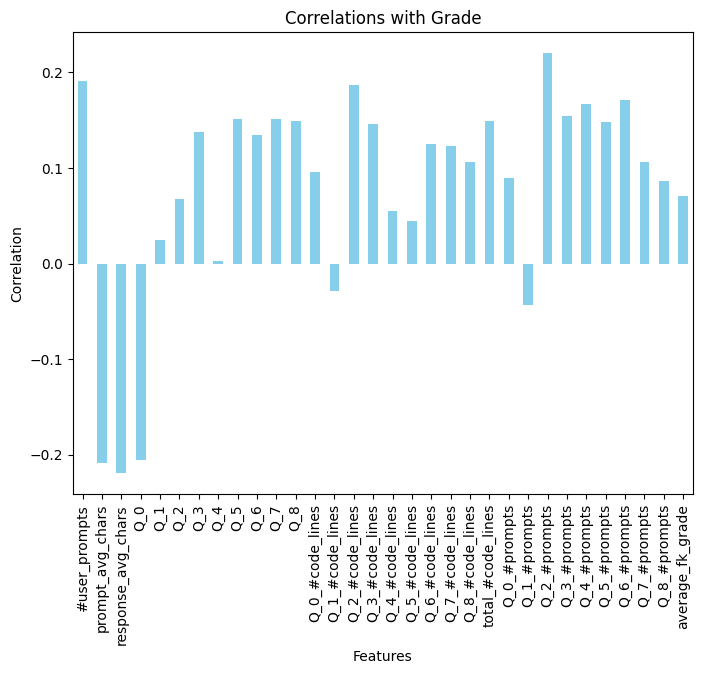

In [643]:
# Calculate correlations with the target variable
correlations_with_target = temp_df.corr()['grade'].drop('grade')

# Plot a bar plot to visualize correlations
plt.figure(figsize=(8, 6))
correlations_with_target.plot(kind='bar', color='skyblue')
plt.title('Correlations with Grade')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

In [644]:
# Create scatter plots for each feature with respect to the target variable
features = temp_df.drop(['grade', 'code'], axis=1)

for feature in features.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=feature, y='grade', data=temp_df, color='skyblue')
    plt.title(f'{feature} vs Grade')
    plt.xlabel(feature)
    plt.ylabel('Grade')

    # Save the plot as a PNG file
    plt.savefig(f'plots/{feature}_scatter_plot.png', bbox_inches='tight')
    plt.close()

In [645]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(122, 32) (122,)


## 4.1. Decision Tree

In [646]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [647]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 0.0
MSE TEST: 144.96
R2 Train: 1.0
R2 TEST: -0.29122366958355905


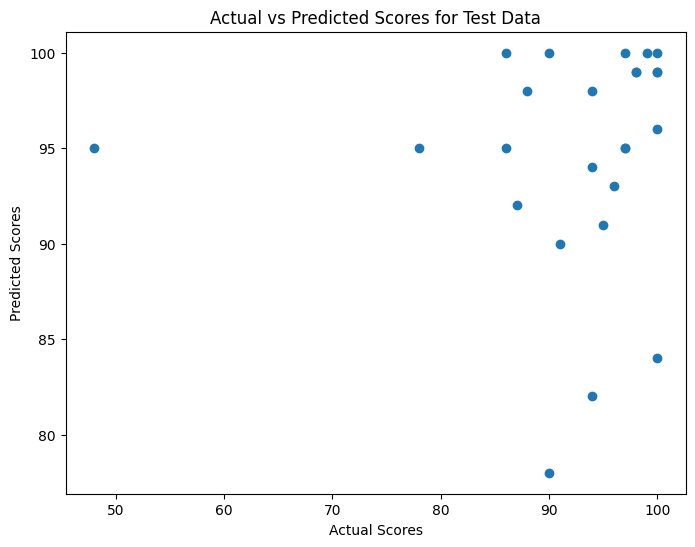

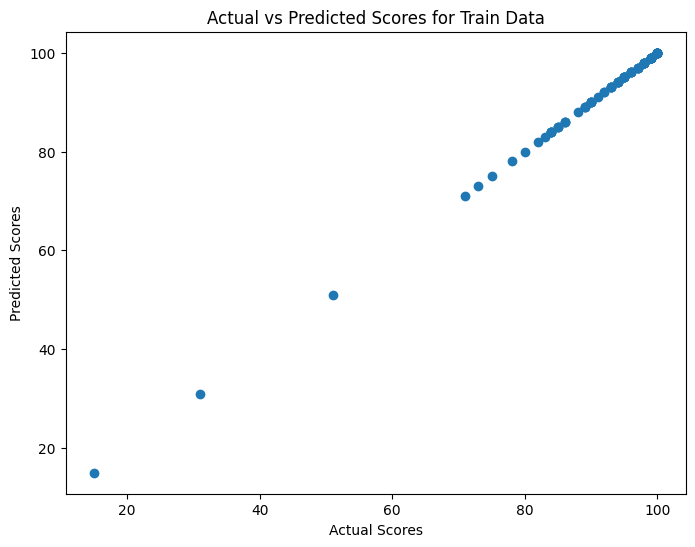

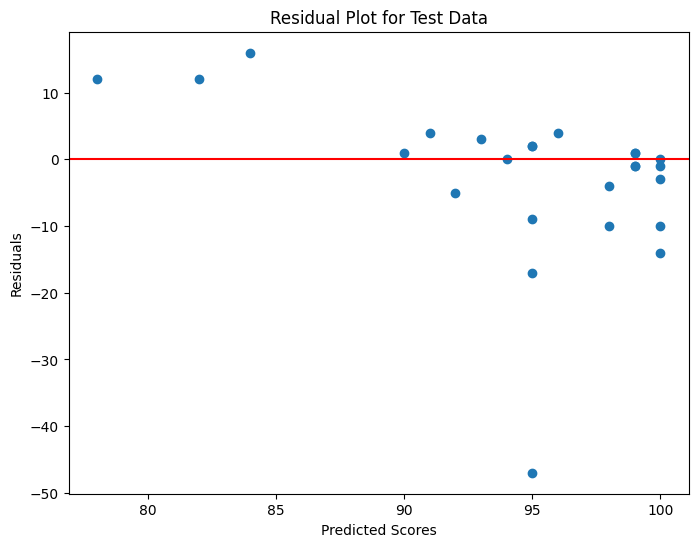

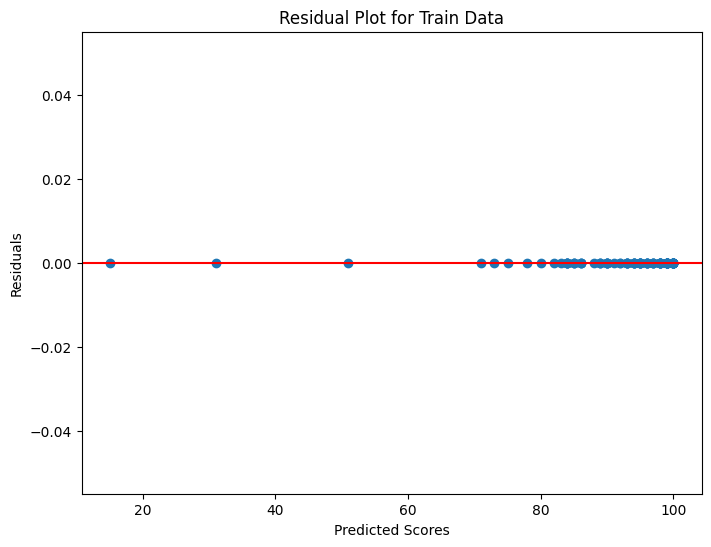

In [648]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Scatter plot for Test Data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores for Test Data')
plt.show()

# Scatter plot for Train Data
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores for Train Data')
plt.show()

# Residual Plot for Test Data
plt.figure(figsize=(8, 6))
residuals_test = y_test - y_test_pred
plt.scatter(y_test_pred, residuals_test)
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.title('Residual Plot for Test Data')
plt.axhline(y=0, color='red', linestyle='-')
plt.show()

# Residual Plot for Train Data
plt.figure(figsize=(8, 6))
residuals_train = y_train - y_train_pred
plt.scatter(y_train_pred, residuals_train)
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.title('Residual Plot for Train Data')
plt.axhline(y=0, color='red', linestyle='-')
plt.show()

#Heatmap of Feature Correlations (assuming X_train is a DataFrame)
#Heatmap için X_traini DataFrame dönüştürmek lazım yaparız


## 4.2. Random Forest

In [649]:
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [650]:
# Prediction
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 29.05831134020618
MSE TEST: 113.79342000000001
R2 Train: 0.8221866938688442
R2 TEST: -0.01360897728244459


### Tune the Model

#### 1. Bayesian Search

In [651]:
# Define the hyperparameters and their search spaces
param_dist = {
    'n_estimators': (50, 250),
    'max_depth': (1, 20),
    'min_samples_split': (2, 25),
    'min_samples_leaf': (1, 10),
    'max_features': (0.1, 0.999),
}

# Create BayesSearchCV
search = BayesSearchCV(estimator=rf_regressor, search_spaces=param_dist, scoring='neg_mean_squared_error', n_iter=50, cv=5, n_jobs=-1, verbose=2)

# Fit the model
search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=1, max_features=0.7117798785370942, min_samples_leaf=4, min_samples_split=9, n_estimators=142; total time=   0.2s
[CV] END max_depth=1, max_features=0.7117798785370942, min_samples_leaf=4, min_samples_split=9, n_estimators=142; total time=   0.2s
[CV] END max_depth=1, max_features=0.7117798785370942, min_samples_leaf=4, min_samples_split=9, n_estimators=142; total time=   0.2s
[CV] END max_depth=1, max_features=0.7117798785370942, min_samples_leaf=4, min_samples_split=9, n_estimators=142; total time=   0.2s
[CV] END max_depth=1, max_features=0.7117798785370942, min_samples_leaf=4, min_samples_split=9, n_estimators=142; total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=6, max_features=0.13099903413168362, min_samples_leaf=7, min_samples_split=7, n_estimators=154; total time=   0.3s
[CV] END max_depth=6, max_features=0.13099903413168362, min_samples_leaf=7, min_sam

#### 2. Grid Search

In [652]:
# First tour

param_grid = {
    "n_estimators": [50, 100, 150],          
    "max_features": ["sqrt", "log2"], 
    "max_depth": [None, 10, 20, 30],           
    "min_samples_split": [2, 5, 10],           
    "min_samples_leaf": [1, 2, 4],             
    "bootstrap": [True, False]
}

# Create the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Create GridSearchCV with verbose
search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit the model
search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


### Evaluation

In [653]:
# Get the best model
best_rf_model = search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {round(mse, 3)}')

print(f"R2 Score on Test Set: {round(100 * r2_score(y_test, y_pred), 3)}%")

Mean Squared Error on Test Set: 93.582
R2 Score on Test Set: 16.642%


## 4.3. XGBoost

In [654]:
xgb_regressor = XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [655]:
# Prediction
y_train_pred = xgb_regressor.predict(X_train)
y_test_pred = xgb_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 4.477583529150411e-07
MSE TEST: 81.20227402488236
R2 Train: 0.9999999972600819
R2 TEST: 0.27669496243833946


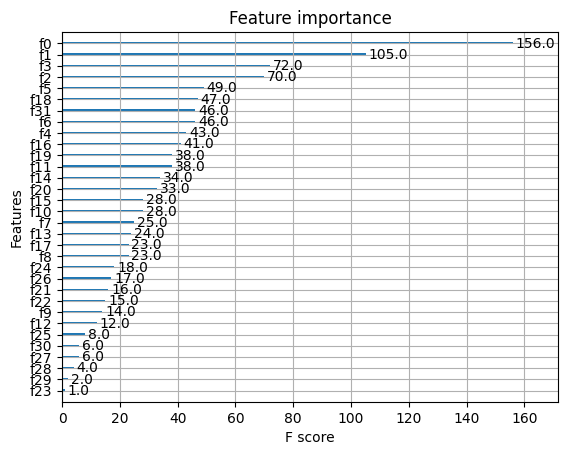

In [656]:
plot_importance(xgb_regressor)
plt.show()

### Feature Selection

* Based on feature importance
* All subset of features (sorted by importance) are evaluated to get the best model

In [657]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor = XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

# Select most important features & re-train
thresholds = np.sort(xgb_regressor.feature_importances_)
best_threshold = 0
best_mse = 1000
best_xgb_model = xgb_regressor

# Set each feature as a threshold and evaluate resulting model on the test set
for thresh in thresholds:
    # Select features using threshold
    selection = SelectFromModel(xgb_regressor, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)

    # Train model with selected features
    eval_set = [(select_X_test, y_test)]
    selection_model = XGBRegressor(early_stopping_rounds=20, eval_metric="rmse")
    selection_model.fit(select_X_train, y_train, eval_set=eval_set, verbose=0)
    
    # Evaluate the trained model
    y_test_pred = selection_model.predict(select_X_test)
    mse = mean_squared_error(y_test,y_test_pred)
    print("Threshold: %.4f, #Features: %d, MSE: %.2f" % (thresh, select_X_train.shape[1], mse))

    if (mse < best_mse):
        best_mse = mse
        best_threshold = thresh
        best_xgb_model = selection_model

print()
print(f"Best threshold: {best_threshold}")
print(f"Best MSE: {round(best_mse, 3)}")

# Select features based on the best threshold
selection = SelectFromModel(xgb_regressor, threshold=best_threshold, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

Threshold: 0.0005, #Features: 32, MSE: 76.51
Threshold: 0.0005, #Features: 31, MSE: 76.51
Threshold: 0.0008, #Features: 30, MSE: 75.00
Threshold: 0.0013, #Features: 29, MSE: 76.55
Threshold: 0.0014, #Features: 28, MSE: 76.53
Threshold: 0.0031, #Features: 27, MSE: 75.66
Threshold: 0.0033, #Features: 26, MSE: 76.29
Threshold: 0.0036, #Features: 25, MSE: 70.29
Threshold: 0.0052, #Features: 24, MSE: 70.29
Threshold: 0.0063, #Features: 23, MSE: 71.08
Threshold: 0.0092, #Features: 22, MSE: 71.03
Threshold: 0.0095, #Features: 21, MSE: 67.95
Threshold: 0.0120, #Features: 20, MSE: 78.77
Threshold: 0.0122, #Features: 19, MSE: 77.99
Threshold: 0.0127, #Features: 18, MSE: 79.43
Threshold: 0.0142, #Features: 17, MSE: 53.43
Threshold: 0.0167, #Features: 16, MSE: 55.52
Threshold: 0.0169, #Features: 15, MSE: 55.42
Threshold: 0.0176, #Features: 14, MSE: 59.99
Threshold: 0.0212, #Features: 13, MSE: 51.05
Threshold: 0.0229, #Features: 12, MSE: 53.11
Threshold: 0.0233, #Features: 11, MSE: 40.98
Threshold:

### Evaluation

Mean Squared Error on Test Set: 40.98355483588821
R2 Score on Test Set: 63.494%


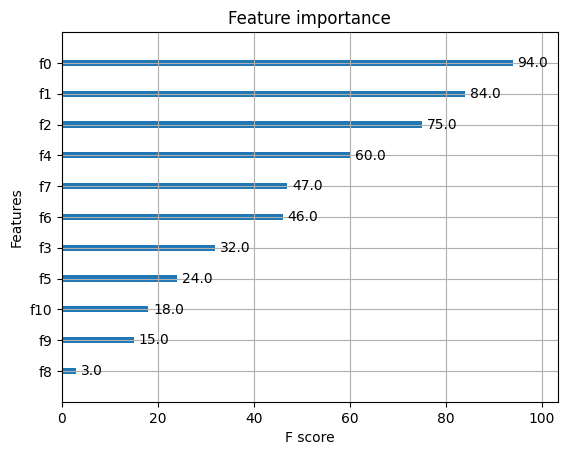

In [658]:
# Make predictions on the test set
y_pred = best_xgb_model.predict(select_X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')
print(f"R2 Score on Test Set: {round(100 * r2_score(y_test, y_pred), 3)}%")

plot_importance(best_xgb_model)
plt.show()

## 4.4 Neural Network

In [659]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

2024-01-19 13:10:43.202100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [660]:
NN_model = Sequential()

# Input layer
NN_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))

# Hidden layers
NN_model.add(Dense(128, activation='relu'))
NN_model.add(Dense(64, activation='relu'))

# Output layers
NN_model.add(Dense(1))

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Standardize the data (optional but often recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

NN_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
NN_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split = 0.2, callbacks=[early_stopping])

Epoch 1/100


2024-01-19 13:11:07.550655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3/3 [==============================] - 1s 131ms/step - loss: 8456.4150 - mae: 90.8753 - val_loss: 8839.5020 - val_mae: 93.8990
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 8291.5625 - mae: 89.9538 - val_loss: 8674.0479 - val_mae: 93.0108
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 8107.1357 - mae: 88.8970 - val_loss: 8474.0332 - val_mae: 91.9240
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 7888.2339 - mae: 87.6287 - val_loss: 8218.3701 - val_mae: 90.5136
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 7604.1113 - mae: 85.9571 - val_loss: 7883.5654 - val_mae: 88.6263
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 7227.9409 - mae: 83.6854 - val_loss: 7449.6509 - val_mae: 86.1078
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 6743.6343 - mae: 80.6169 - val_loss: 6898.6768 - val_mae: 82.7789
Epoch 8/100
3/3 [============================

In [661]:
# Evaluate the model on the test set
test_loss, test_mae = NN_model.evaluate(X_test_scaled, y_test)
test_loss = round(test_loss, 2)
test_mae = round(test_mae, 2)
print(f'Test Mean Squared Error: {test_loss}')
print(f'Test Mean Absolute Error: {test_mae}')

1/1 [==============================] - 0s 93ms/step - loss: 613.4781 - mae: 19.9888
Test Mean Squared Error: 613.48
Test Mean Absolute Error: 19.99


## 4.5. Linear Regression

In [662]:
from sklearn.linear_model import LinearRegression

In [663]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

LinearRegression()

In [664]:
# Prediction
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 103.53749058762818
MSE TEST: 97.72888035097269
R2 Train: 0.3664345014971212
R2 TEST: 0.12948507511675267
